# The Advanced Computing Center for Research and Education
The Advanced Computing Center for Research and Education (ACCRE) is a computer cluster serving the high-performance computing needs of research for Vanderbilt University. In this data question, you will be analyzing data on jobs run on ACCRE's hardware.

When a job is submitted to ACCRE, it goes through the slurm scheduler, which tracks and manages compute and memory resources. It is hypothesized that the slurm scheduler is processing so many job completions so frequently that it sometimes becomes unresponsive to commands from users trying to schedule new jobs or check job status. This is a particularly bad problem for clients who use automated submission systems, such as members of the Open Science Grid. The goal of this project is to investigate and potentially confirm that hypothesis that lots of job completions in a short time period are causing the scheduler to be unresponsive, and determine the rough threshold at which it becomes an issue.

You have been provided three datasets for this task:

- fullsample.csv: This file contains output for jobs run through the slurm scheduler.
- slurm_wrapper_ce5.log and slurm_wrapper_ce6.log: Logs of every slurm command that a pair of servers, ce5 and ce6, executed, how long it took, and if it succeeded. These servers connect ACCRE's local cluster to the Open Science Grid and submit jobs to slurm on behalf of the grid.

To get started, answer the following questions using just the fullsample.csv jobs dataset:

1. Calculate some descriptive statistics for how many jobs per hour are being completed. What does the completions per hour look like over the time span of the dataset? Are there weekly trends, and has it been increasing over the last year?


2. Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. We also expect that most job completions will be in the "production" partition, but is this actually true?



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
import calendar
import re
import math

In [2]:
#readind data 
fs_df = pd.read_csv('../data/fullsample.csv')
fs_df = fs_df[fs_df['END'] != 'Unknown'] # drop these 651 rows, all have EXITCODE 0:0

#change the format of the date/time
fs_df['BEGIN'] = pd.to_datetime(fs_df['BEGIN'], format='%Y-%m-%dT%H:%M:%S')
fs_df['END'] = pd.to_datetime(fs_df['END'], format='%Y-%m-%dT%H:%M:%S')
#fs_df.head(3)

In [3]:
#change the format of requested memory and chnage its type to int
fs_df['REQMEM'] = fs_df['REQMEM'].str[0:-2].astype('int')

#change the used momory 
fs_df['USEDMEM'] = fs_df['USEDMEM'].apply(lambda x: x[0:-1] if x[-1] == 'M' else '0', ).astype(float)
#fs_df.head(3)

In [4]:
fs_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7395234 entries, 1 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   JOBID      object        
 1   STATE      object        
 2   BEGIN      datetime64[ns]
 3   END        datetime64[ns]
 4   REQMEM     int64         
 5   USEDMEM    float64       
 6   REQTIME    object        
 7   USEDTIME   object        
 8   NODES      int64         
 9   CPUS       int64         
 10  PARTITION  object        
 11  EXITCODE   object        
dtypes: datetime64[ns](2), float64(1), int64(3), object(6)
memory usage: 733.5+ MB


In [5]:
#read the data into a df
fs_df.to_csv('../data/fs_df.csv', index= False)

In [6]:
#setting the index to END
end_time=fs_df.set_index('END')
end_time.head(3)

,JOBID,STATE,BEGIN,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
END,,,,,,,,,,,
2021-09-05 11:36:32,30853133,COMPLETED,2021-08-06 11:36:09,262144,20604.62,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2021-09-05 19:04:53,30858137,COMPLETED,2021-08-06 19:04:39,204800,57553.77,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
2021-09-07 20:52:55,30935078,COMPLETED,2021-08-09 16:52:51,65536,20577.96,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0


In [7]:
#subsetting the data to the completed ones 
completed=end_time.loc[end_time['STATE']=='COMPLETED']
completed.head(3)

,JOBID,STATE,BEGIN,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
END,,,,,,,,,,,
2021-09-05 11:36:32,30853133,COMPLETED,2021-08-06 11:36:09,262144,20604.62,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2021-09-05 19:04:53,30858137,COMPLETED,2021-08-06 19:04:39,204800,57553.77,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
2021-09-07 20:52:55,30935078,COMPLETED,2021-08-09 16:52:51,65536,20577.96,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0


In [8]:
#completed number of jobs in 24 hours 
completed['JOBID'].resample(pd.Timedelta('24 hours')).count()

END
2020-10-01    33263
2020-10-02    30356
2020-10-03    15346
2020-10-04    17532
2020-10-05    24119
              ...  
2021-10-03     1561
2021-10-04      614
2021-10-05      727
2021-10-06      265
2021-10-07      320
Freq: D, Name: JOBID, Length: 372, dtype: int64

In [9]:
#completed number of jobs in 1 hour
completed['JOBID'].resample(pd.Timedelta('1 hour')).count()

END
2020-10-01 00:00:00     421
2020-10-01 01:00:00    1080
2020-10-01 02:00:00    1137
2020-10-01 03:00:00    1018
2020-10-01 04:00:00    1244
                       ... 
2021-10-07 16:00:00       8
2021-10-07 17:00:00       8
2021-10-07 18:00:00       8
2021-10-07 19:00:00       8
2021-10-07 20:00:00       6
Freq: H, Name: JOBID, Length: 8925, dtype: int64

In [10]:
#count of jobs per hour 
completed_by_hour=completed.resample('H').count()
completed_by_hour.head(3)

,JOBID,STATE,BEGIN,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
END,,,,,,,,,,,
2020-10-01 00:00:00,421,421,421,421,421,421,421,421,421,421,421
2020-10-01 01:00:00,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080,1080
2020-10-01 02:00:00,1137,1137,1137,1137,1137,1137,1137,1137,1137,1137,1137


In [11]:
completed_jobs=completed_by_hour['JOBID']

In [12]:
completed_jobs

END
2020-10-01 00:00:00     421
2020-10-01 01:00:00    1080
2020-10-01 02:00:00    1137
2020-10-01 03:00:00    1018
2020-10-01 04:00:00    1244
                       ... 
2021-10-07 16:00:00       8
2021-10-07 17:00:00       8
2021-10-07 18:00:00       8
2021-10-07 19:00:00       8
2021-10-07 20:00:00       6
Freq: H, Name: JOBID, Length: 8925, dtype: int64

In [13]:
#1 job is canceled by user 9204 
fs_df.loc[fs_df['STATE'] == 'CANCELLED by 9204', 'EXITCODE'].value_counts()

1:0    1
Name: EXITCODE, dtype: int64

In [14]:
#counts of completed ones
fs_df.loc[fs_df['STATE'] == 'COMPLETED'].value_counts()
fs_df.loc[fs_df['STATE'] == 'COMPLETED'].value_counts().sum()

7375084

In [15]:
# counts of completed ones and their exit code (0:0)
fs_df.loc[fs_df['STATE'] == 'COMPLETED', 'EXITCODE'].value_counts()

0:0    7375084
Name: EXITCODE, dtype: int64

In [16]:
# filter down to only COMPLETED state
fs_comp = fs_df[fs_df['STATE'] == 'COMPLETED']
fs_comp.head(3)

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144,20604.62,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800,57553.77,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536,20577.96,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0


In [18]:
#counts of completions per hour 
ended_per_hour = (fs_comp.set_index('END')
                       .sort_values('END', ascending = True)
                       .rolling('1h')
                        ['JOBID']
                        .count()
                )
ended_per_hour

END
2020-10-01 00:10:15    1.0
2020-10-01 00:12:58    2.0
2020-10-01 00:13:31    3.0
2020-10-01 00:17:23    4.0
2020-10-01 00:17:53    5.0
                      ... 
2021-10-07 20:11:21    9.0
2021-10-07 20:17:24    9.0
2021-10-07 20:26:01    8.0
2021-10-07 20:32:45    9.0
2021-10-07 20:41:11    9.0
Name: JOBID, Length: 7375084, dtype: float64

In [19]:
# define a function to calculate total hours of a timedelta
def td_hours(timedelta):
    hours = timedelta.days*24 + timedelta.seconds/3600
    return hours

In [20]:
# overall completions per hour 
completions = len(fs_comp)
time_diff = (fs_df['END'].max() - fs_df['END'].min())
jobs_per_hour = completions/td_hours(time_diff)
print(round(jobs_per_hour, 1), 'completions per hour')


826.4 completions per hour


In [21]:
ended_per_hour_by_week = (fs_comp.groupby(
                                    pd.Grouper(key = 'END', freq = 'W')) # Group by week
                                 ['JOBID'] # Counting job ids
                                 .count()/168 # divide count by 168 hours in a week
                        )
ended_per_hour_by_week.head(3)

END
2020-10-04     574.386905
2020-10-11    1221.565476
2020-10-18     672.672619
Freq: W-SUN, Name: JOBID, dtype: float64

In [22]:
# rename two columns
ended_per_hour_by_week = (ended_per_hour_by_week.reset_index()
                                              .rename(columns = {'END': 'WEEK OF', 
                                                                 'JOBID': 'COMPLETIONS PER HOUR'}
                                                     )
                        )
ended_per_hour_by_week.head(3)

,WEEK OF,COMPLETIONS PER HOUR
0,2020-10-04,574.386905
1,2020-10-11,1221.565476
2,2020-10-18,672.672619


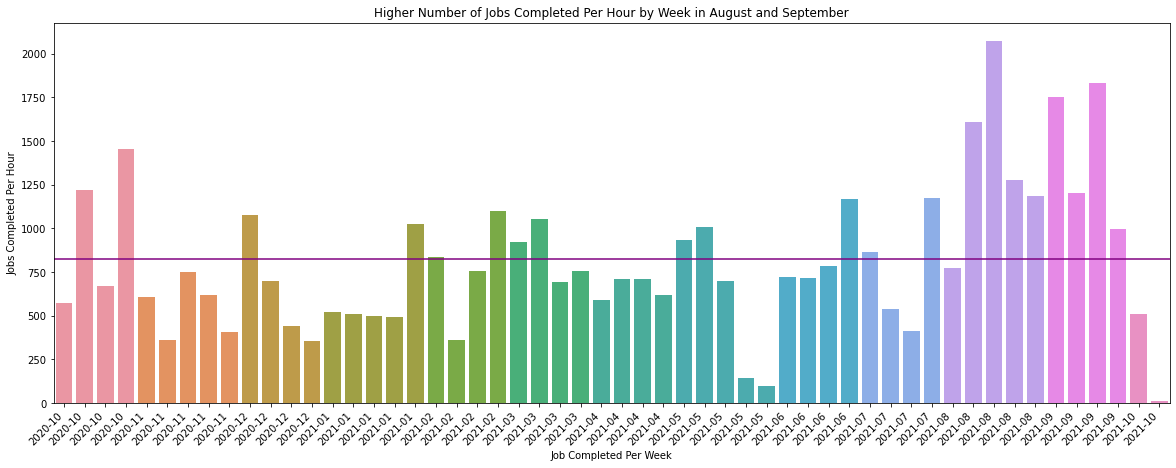

In [23]:
# Plot completions per hour by week
fig, ax = plt.subplots(figsize=(20,7))

x_dates = ended_per_hour_by_week['WEEK OF'].dt.strftime('%Y-%m')

sns.barplot(x = 'WEEK OF',
            y = 'COMPLETIONS PER HOUR',
            data = ended_per_hour_by_week,
            ax = ax,
            hue = x_dates,
            dodge = False
           )


ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')
ax.get_legend().remove()
ax.axhline(jobs_per_hour, color = 'purple')
ax.set(xlabel = 'Job Completed Per Week',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Higher Number of Jobs Completed Per Hour by Week in August and September')
plt.show()

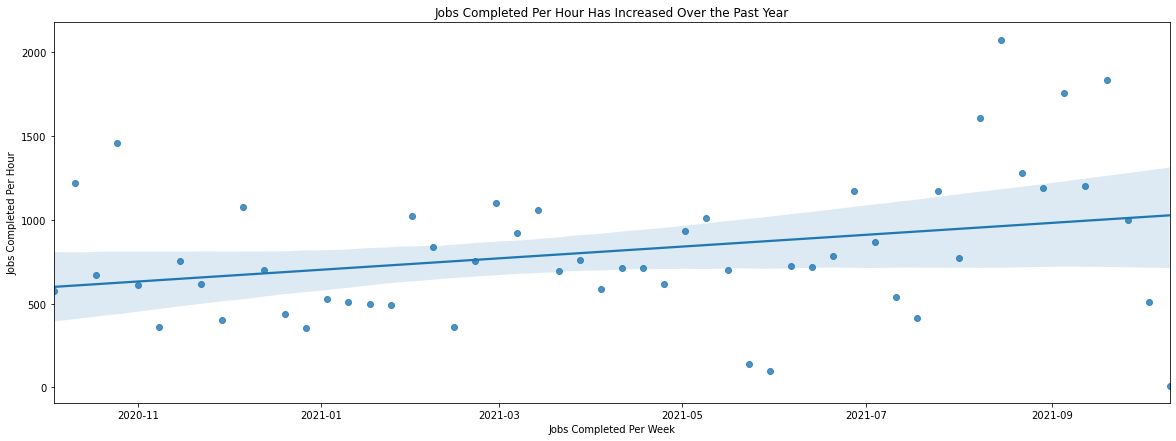

In [25]:
# Plot completions per hour by week along with trendline, which shows gradual increase over the year
fig, ax = plt.subplots(figsize=(20,7))

ax.xaxis.update_units(ended_per_hour_by_week['WEEK OF'])

sns.regplot(x = ax.xaxis.convert_units(ended_per_hour_by_week['WEEK OF']),
            y = 'COMPLETIONS PER HOUR',
            data = ended_per_hour_by_week,
            ax = ax,
           )

ax.set(xlabel = 'Jobs Completed Per Week',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour Has Increased Over the Past Year')
plt.show()

In [26]:
#jobs completed per hour per day
ended_per_hour_by_day = (fs_df.groupby(
                                    pd.Grouper(key = 'END', freq = 'D')) # Group by day
                                    ['JOBID'] # Counting job ids
                                    .count()/24 # divide count by 24 hours in a day
                        )

In [27]:
# display with renamed columns
ended_per_hour_by_day = (ended_per_hour_by_day.reset_index()
                                              .rename(columns = {'END': 'DAY', 
                                                                 'JOBID': 'ENDEDPERHOUR'}
                                                     )
                        )

In [28]:
ended_per_hour_by_day

,DAY,ENDEDPERHOUR
0,2020-10-01,1386.708333
1,2020-10-02,1265.625000
2,2020-10-03,640.333333
3,2020-10-04,732.541667
4,2020-10-05,1006.916667
...,...,...
367,2021-10-03,81.416667
368,2021-10-04,25.750000
369,2021-10-05,30.375000
370,2021-10-06,11.708333


In [29]:
# Add weekday and weekday number to completions per hour by day
ended_per_hour_by_day['WEEKDAY'] = ended_per_hour_by_day['DAY'].apply(lambda x: calendar.day_name[x.weekday()])
ended_per_hour_by_day['WEEKDAY NUMBER'] = ended_per_hour_by_day['DAY'].apply(lambda x: x.weekday()+1)
ended_per_hour_by_day

,DAY,ENDEDPERHOUR,WEEKDAY,WEEKDAY NUMBER
0,2020-10-01,1386.708333,Thursday,4
1,2020-10-02,1265.625000,Friday,5
2,2020-10-03,640.333333,Saturday,6
3,2020-10-04,732.541667,Sunday,7
4,2020-10-05,1006.916667,Monday,1
...,...,...,...,...
367,2021-10-03,81.416667,Sunday,7
368,2021-10-04,25.750000,Monday,1
369,2021-10-05,30.375000,Tuesday,2
370,2021-10-06,11.708333,Wednesday,3


In [30]:
# Aggregate by weekday
ended_per_hour_weekday = ended_per_hour_by_day.groupby(['WEEKDAY NUMBER', 'WEEKDAY'], as_index = False)['ENDEDPERHOUR'].mean()
ended_per_hour_weekday

#highest number of completions during Monday_Wednesday

,WEEKDAY NUMBER,WEEKDAY,ENDEDPERHOUR
0,1,Monday,881.209119
1,2,Tuesday,1022.036950
2,3,Wednesday,929.574686
3,4,Thursday,797.590278
4,5,Friday,807.621069
5,6,Saturday,666.738994
6,7,Sunday,694.043239


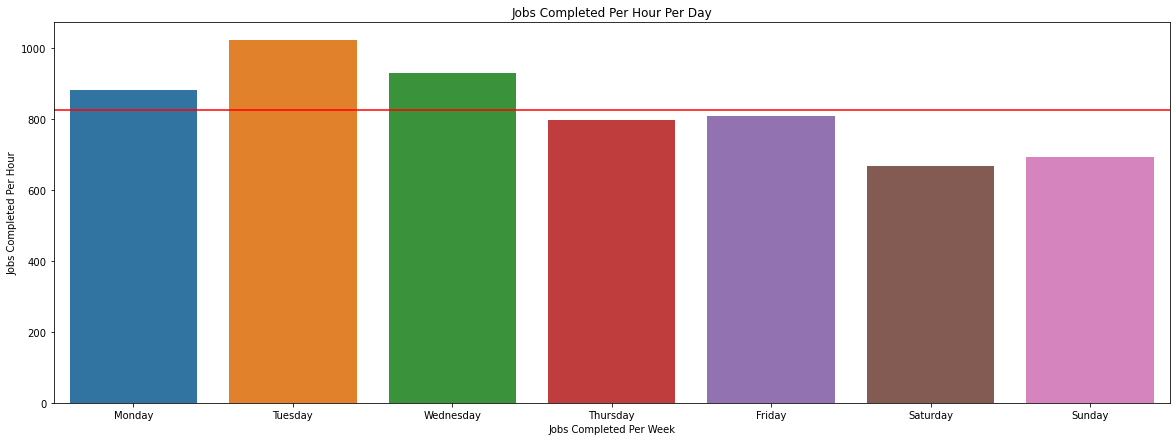

In [31]:
# Plot completions per hour by weekday
fig, ax = plt.subplots(figsize=(20,7))

sns.barplot(x = 'WEEKDAY',
            y = 'ENDEDPERHOUR',
            data = ended_per_hour_weekday,
            ax = ax,
           )

ax.axhline(jobs_per_hour, color = 'red')
ax.set(xlabel = 'Jobs Completed Per Week',
       ylabel = 'Jobs Completed Per Hour',
       title = 'Jobs Completed Per Hour Per Day')
plt.show()

#Monday through Wednesday are the days that are above the average completions per hour per day

<BarContainer object of 7 artists>

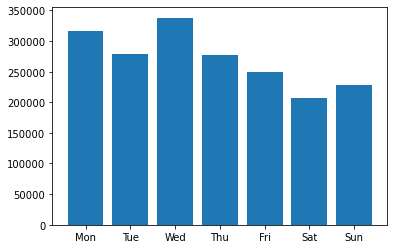

In [32]:
#another graph showing number of jobs per day 
jobs_weekday = [len(fs_df[fs_df['BEGIN'].dt.day == x]) for x in range(1,8)]
ax.axhline(jobs_per_hour, color = 'red')
plt.bar(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], jobs_weekday)


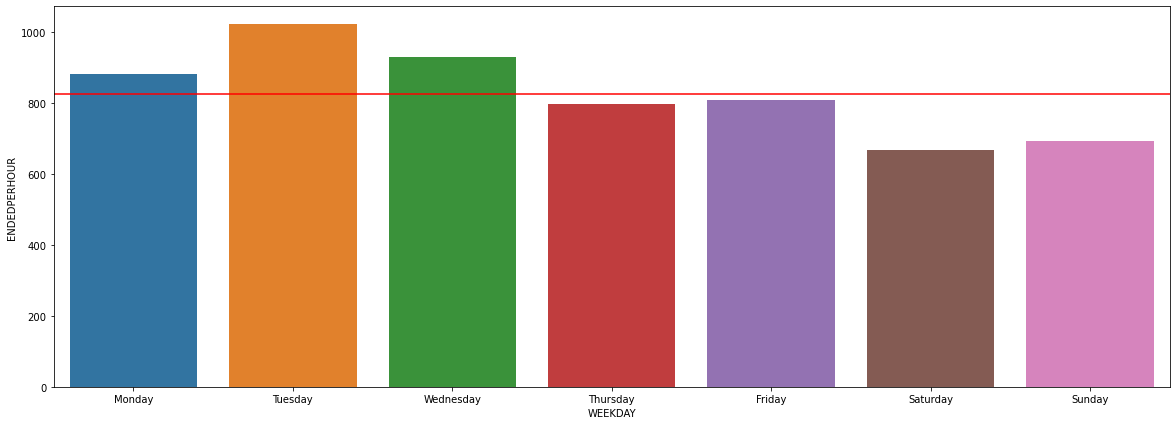

In [33]:
fig, ax = plt.subplots(figsize=(20,7))
sns.barplot(x = 'WEEKDAY',
            y = 'ENDEDPERHOUR',
            data = ended_per_hour_weekday,
            ax = ax,
           )
ax.axhline(jobs_per_hour, color = 'red')
plt.show()


<BarContainer object of 24 artists>

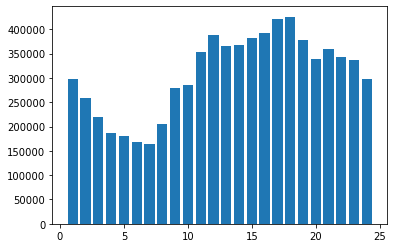

In [34]:
#plot jobs per hour per day
jobs_hour = [len(fs_df[fs_df['BEGIN'].dt.hour == x]) for x in range(0,24)]
hours = [x for x in range(1,25)]
plt.bar(hours, jobs_hour)

#### 2. Does the job state affect completions per hour? i.e. if I only look at jobs with exit code 0:0 in the "COMPLETED" state, is that a similar number of completions per hour as with all jobs, failed or cancelled? This will indicate if the load on the scheduler is by user design or is a result of users not sufficiently testing their jobs before submitting very large arrays. We also expect that most job completions will be in the "production" partition, but is this actually true?

In [35]:
#counts of exitcodes
#fs_df.value_counts('EXITCODE')

#EXITCODE 0:0 = SUCCESS
#EXITCODE 0:15, 0:9, 0:2 = CANCELLED
#EXITCODE 1:0, 2.0= FAILED

#counts of state
#fs_df.value_counts('STATE')

#gives us the specific exitcodes we want 
#fs_df[fs_df['EXITCODE'] == '0:125']
#fs_df[fs_df['EXITCODE'] == '0:7']

#more extra codes
#fs_df[fs_df['STATE'].str.match(r'CANCELLED')]
#fs_df[fs_df['STATE'].str.match(r'CANCELLED')].value_counts('EXITCODE')
#fs_df[fs_df['STATE'].str.match(r'FAILED')].value_counts('EXITCODE')
fs_can = fs_df[fs_df['STATE'] == 'CANCELLED']
fs_fail=fs_df[fs_df['STATE'] == 'FAILED']

In [36]:
#counts of cancelled jobs per hour 
can_per_hour = (fs_can.set_index('END')
                       .sort_values('END', ascending = True)
                       .rolling('1h')
                        ['JOBID']
                        .count()
                )
#can_per_hour

<AxesSubplot:xlabel='END'>

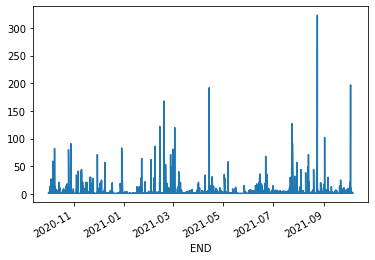

In [37]:
can_per_hour.plot()

In [38]:
#counts of failed jobs per hour 
fail_per_hour = (fs_fail.set_index('END')
                       .sort_values('END', ascending = True)
                      .rolling('1h')
                        ['JOBID']
                        .count()
                )
#fail_per_hour

<AxesSubplot:xlabel='END'>

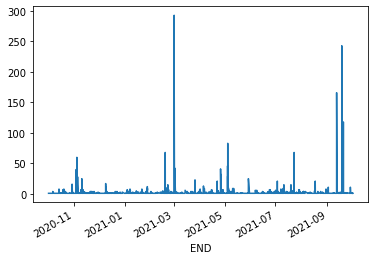

In [39]:
fail_per_hour.plot()

In [40]:
#cleaning up cancelled data and getting the count of different states  
fs_df['STATE'] = fs_df['STATE'].str.replace(r'CANCELLED by \d*', 'CANCELLED by USER', regex=True)
fs_df['STATE'].value_counts()

COMPLETED            7375084
CANCELLED               9055
CANCELLED by USER       5588
FAILED                  3766
OUT_OF_MEMORY           1739
NODE_FAIL                  2
Name: STATE, dtype: int64

In [41]:
#grouping by the data by the state 
fs_df_states = (fs_df.groupby('STATE', as_index = False)
                    .rolling('1h', on = 'END')
                    ['JOBID']
                    .count()
                    .reset_index()
                )
fs_df_states.head(3)

,STATE,END,JOBID
0,CANCELLED,2021-09-05 10:53:57,1.0
1,CANCELLED,2021-09-05 02:46:09,1.0
2,CANCELLED,2021-09-05 02:54:09,2.0


In [42]:
#per hour proportion of each state 
fs_df_all_states = (fs_df_states
                 .groupby('STATE', as_index = False)
                 ['JOBID']
                 .mean()
                 .rename(columns = {'JOBID': 'PER_HOUR'})
)

fs_df_all_states['PER_HOUR_PROP'] = fs_df_all_states['PER_HOUR']/fs_df_all_states['PER_HOUR'].sum()
fs_df_all_states.sort_values('PER_HOUR', ascending = False)

,STATE,PER_HOUR,PER_HOUR_PROP
2,COMPLETED,301000.741870,0.995489
1,CANCELLED by USER,487.862563,0.001613
0,CANCELLED,385.693650,0.001276
5,OUT_OF_MEMORY,288.545141,0.000954
3,FAILED,200.730218,0.000664
4,NODE_FAIL,1.000000,0.000003


In [ ]:
fs_df_all_states.sort_values('PER_HOUR', ascending = False)['STATE']

In [43]:
#average number of jobs per hour 
jobs_per_hour

826.3847997227114

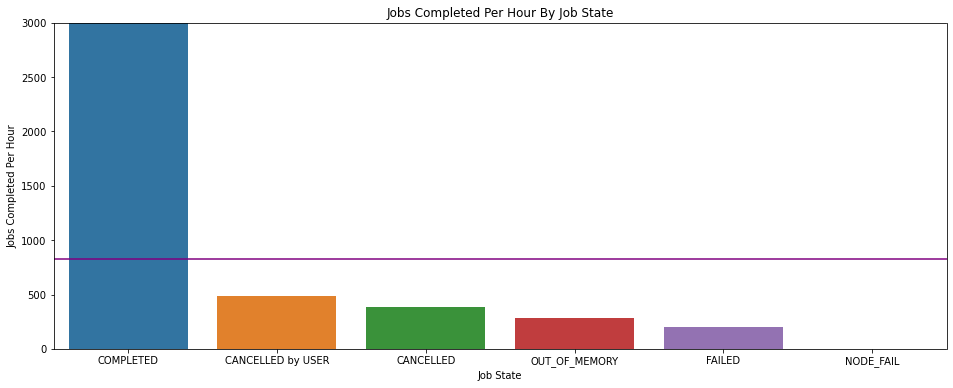

In [44]:
#plotting jobs completed per hour in each job state 
fig, ax = plt.subplots(figsize=(16,6))

sns.barplot(x = 'STATE',
            y = 'PER_HOUR',
            data = fs_df_all_states,
            order = fs_df_all_states.sort_values('PER_HOUR', ascending = False)['STATE'],
            ax = ax,
           )
ax.axhline(jobs_per_hour, color = 'purple')
ax.set(xlabel='Job State', ylabel= 'Jobs Completed Per Hour', ylim=(0,3000))
ax.set_title('Jobs Completed Per Hour By Job State')        
plt.show()

In [45]:
#proportion of partitions used 
partitions_count = fs_df['PARTITION'].value_counts().reset_index().rename(columns = {'index': 'PARTITION', 'PARTITION':'COUNT'})
partitions_prop = fs_df['PARTITION'].value_counts(normalize = True).round(4).reset_index().rename(columns = {'index': 'PARTITION', 'PARTITION':'PROPORTION'})
partitions_count.merge(partitions_prop)

,PARTITION,COUNT,PROPORTION
0,production,7019136,0.9491
1,nogpfs,147044,0.0199
2,pascal,124451,0.0168
3,sam,64967,0.0088
4,turing,21412,0.0029
5,maxwell,11278,0.0015
6,cgw-maizie,4308,0.0006
7,debug,1616,0.0002
8,cgw-platypus,376,0.0001
9,cgw-dsi-gw,228,0.0000
